In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-03-03 06:47:49--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-03-03 06:47:50 (56.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


The text is a sequence of text.  `set` gives the set of all characters that uniquely occur in the text.  Then `list` converts to an arbitrary ordering of this set, and then we sort them.


The number of these is our vocabulary size.  Theere are 65 total unique characters in the dataset.  

Next we need some strategy to "tokenize" the text.  When people say this, they mean convert raw text to some sequence of integers according to some vocabulary of possible elements.  Here, we are translating individual characters to integers.  Let's look at this...

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


When we `encode`, we receive a list of integers.  Then we can reverse this to get back the exact string with `decode`.  

We basically create a look-up table from character to integer and vice-versa.  This is only one of many possible encodings, such as sub-word based (`SentencePiece`, `BytePairEncodings`, etc).  Let's stick with this simple scheme for now.

In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

This is an identical translation of the Shakespeare text using our vocabulary mapping, as a single very large sequence of integers

In [ ]:
# Let's now split up the data into train and validation sets, so we don't just memorize all of the data.  It should
# be able to produce new text that is like the training text.
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
# We're never going to put the entire text all at once.  This is too expensive.
# When we train the transformer, we work with chunks of the dataset, and we randomly
# sample different chunks.  Each chunk has a maximum length and we will call this `block_size`.
block_size = 8
train_data[:block_size+1]  # let's look at the first `block_size` + 1 in the training data

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

This has multiple examples packed in to a single example.  We will simultaneously train it to make predictions at every single position.  For 9 characters, we have 8 examples in it.

In the context of [18] (the first character), 47 comes next.
In the context of [18, 47] (the first 2 characters), 56 comes next.
And so on...

In [ ]:
# Let's spell this out in code
x = train_data[:block_size]
y = train_data[1:block_size+1]  # targets for each position in the sequence.  notice offset by 1!
for t in range(block_size):
    context = x[:t+1]  # up to and including t
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


This is important b/c it presents to the model sequences of different lengths, up to the maximum sequence length (or block_size).  This way, when we want to do generation of new sequences, we can start with a sequence as short as 1 character, and the transformer knows what to do with a sequence of length 1 to start iteratively producing new sequences.

After we get to block_size, we start truncating b/c the transformer doesn't know what to do with sequences larger than that.

In [ ]:
# Let's extend this to have a batch dimension.  We will stack multiple sequences
# into a single tensor for better efficiency.  They are processed independently.
#
# We will start randomly generated sequences from the dataset.
#
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    ### generate a small batch of data of inputs x and targets y

    # Choose if we sample from the train or val split
    data = train_data if split == 'train' else val_data

    # When we generate random positions, we generate batch_size number of random offsets,
    # each of can support sequences of length block_size.
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Then generate the input sequences and targets, which are offset by 1
    # from the inputs.  Stack them all up as individual rows in a tensor.
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

# 32 independent examples pack in to a single batch!
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [ ]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


(back to the slides)  Let us start to create what is the simplest possible language model, called the `Bigram Language Model`.  

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            # This allows us to optionally not have a targets, for example
            # if we don't need the loss and are just doing inferencing/generation.
            loss = None
        else:
            # PyTorch expects the channels to be the 2nd dimension, so we
            # need to do some reshaping.
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


Note that since we know that we have 65 elements in the vocabulary, we can actually guess at what the loss should be when we start off.  In particular, we are expecting `-ln(1/65) ~ 4.17`.  We are getting 4.87, and so initial predictions are not super diffuse and have some entropy.  

Now let's add the ability to generate new sequences.

In [ ]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context.
        #
        # the job of this function is to take the (B, T) sequence, and extend
        # it to be (B, T+1), and then (B, T+2), and so on, until we have extended
        # it to `max_new_tokens` additional length.
        for _ in range(max_new_tokens):
            # get the predictions with current indices.  ignore the loss.
            logits, loss = self(idx)
            # focus only on the last time step, so pluck out the last element in the time dimension
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution to get a single prediction for what comes next according to the given PDF
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# Create a batch size of 1, with time dimension of 1, each holding zeros to start
# the generation process.  The first element of every sequence will start with 0 (e.g., the newline character).
# Ask for 100 new tokens.  the generate function will continue this.  This operates on batches,
# so we need to index the 0'th element to get the sequence generated.  Convert these generated
# indices into a Python list and feed into our decode function to convert back into text.
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


This is total garbage, b/c we need to TRAIN the model.  So let's start doing that.  But note that while we are feeding it entire sequences, it is only using single characters to make the next prediction.  We are doing this so we can build this up to actually use the history to make the next prediction.

In [ ]:
# create a PyTorch optimizer
#
# Typical good setting for lr is 3e-4, but for small networks we can use larger
# learning rates.  We can probably even go higher to 1e-2.  Let's use 1e-3.
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
# a very typical training loop
batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


2.5727508068084717


We can increase the number of iterations to keep pushing down the loss, though it'll plateau b/c it is a very simple model.

In [ ]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=400)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenou


The loss has improved, and while it's not what we're looking for it seems it a bit more reasonable.  It's certainly not Shakespeare but it is making progress.  Ok this is the simplest possible model.  The tokens are not talking to each other.  We look only at the last character to make the next prediction.  Let's start to have the tokens talking to each other.

## The Mathematical Trick for Self-Attention

This is at the heart of an efficient implementation of self-attention.  Let's look first at a toy example

In [ ]:
# consider the following toy example

torch.manual_seed(1337)
B,T,C = 4,8,2  # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

We would like these tokens (up to 8 tokens in a batch) to talk to each other.  In particular, we want to couple them in a very specific way.  For example, the token at the 5th location should not interact with the 6th, 7th, or 8th location.  It can only talk to tokens at the 1st, 2nd, 3rd, and 4th.  Information can only flow from the past to the present, and not the future b/c we are trying to predict the future.

What is the easiest way for tokens to communicate?  If we are at the 5th token and we want to communicate with our past, the simplest thing we can do is to do an average of all the preceding tokens.  Take the channels that make up the information from the 1st, 2nd, 3rd, 4th, and 5th (e.g., "now") steps and average them up.  This becomes a feature vector that summarizes "me" in the context of the past.

This is an extremely weak and lossy form of interaction.  But we will see how to bring this information back later on.

In [ ]:
# For every element in the batch, and for each token in the sequence, we will compute
# the average of all tokens up to the current token, and do this for all tokens in the batch.
# Each sequence in the batch is treated independent from one another.

# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))  # "bag of words"
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C): everything up to and including the t_th token
        xbow[b,t] = torch.mean(xprev, 0)

In [ ]:
x[0]  # 0th batch element

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [ ]:
# If we now look at the 0th element at xbow, we see the following
#
# the first element is identical to the first element in x.  this is b/c there's nothing prior to average with.
# the second element is the mean of the first and second elements in x
# the third element is the mean of the first, second, and third elements in x
# ... and so on...
#
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

This is all well and good, but it is very inefficient.  We can, however, be very efficient in doing this by using matrix multiplication

In [ ]:
torch.manual_seed(42)
a = torch.ones(3, 3)
b = torch.randint(0, 10, (3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)


a=
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


We have a single matrix `a` of all ones, which is 3x3 dims.  We also have a matrix `b` which is a matrix of size 3x2 dims, which contains random integers in the range [0, 10).  

We then multiply these together to get `c` which will be a matrix of size 3x2.

How are these numbers in `c` achieved?  The number in the top left is the first row of `a` dot-producted with the first row of `b`.  And so on.

The repeated elements in `c` are repeated b/c all of the rows in `a` are all 1's.  The trick is the following: `a` is a boring matrix of all 1's.  But torch has a function called `tril` which you can wrap with a matrix of all 1's, and get the following:

In [ ]:
# The lower triangular portion of the input.
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

OK let's substitute this instead for `a`

In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
b = torch.randint(0, 10, (3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)


a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


Again, its the dot product of rows in `a` with columns in `b`.  But now, we have 0's ignoring certain elements in `b`. Now, in each row of `c`, we are basically doing a sum of a variable number of rows in `b`.  This is currently sums b/c `a` is 1's, but you see how we can do averages by normalizing the rows of `a` to sum to 1:

In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)


a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


We see now that the rows in `a` all sum to 1, and when we multiply this with `b`, we get averages of all preceding tokens, and all future tokens are ignored with 0's still.  The first row in `c` is still the first row in `b`, but the second row in `c` is now the average of the first two rows in `b`, and so on.  By manipulating the elements of the multiply matrix, we can do these averages in this incremental fashion.  

In [ ]:
# version 2: using matrix multiply for a weighted aggregation

# Let's go back to what we were doing before and try to do it more efficiently.
wei = torch.tril(torch.ones(T, T))  # short for "weights"
wei = wei / wei.sum(1, keepdim=True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

This represents how much of every row we want to average up together, b/c each row sums to 1.

In [ ]:
xbow2 = wei @ x  # (T, T) @ (B, T, C) --->

# Well PyTorch will see this and see the dimensions don't match.  So it will first
# add a batch dimension to `wei` so that it is (B, T, T), and then it will apply
# this matrix multiplication in batched form, in parallel, and individually.
# For each batch element, it is multiplying a (T, T) @ (T, C) ---> (T, C), and
# you will end up with a (B, T, C) after the batched multiplication.

Now, `xbow` and `xbow2` are equivalent.

Again, the trick was we were able to do batched matrix multiplcation with some weights, and do weighted sums that take on this triangular form to combine samples in the past together.

In [ ]:
xbow[0], xbow2[0]

(tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

Let's do this in one more way.

`wei` begins with all zeros.  Then we use `masked_fill`, which says for all elements where `tril == 0`, make them negative infinity in `wei`.  And the final line then takes the Softmax along every single row in `wei`, this will normalize each row to sum to 1, and we get the same exact matrix.  In Softmax, we exponentiate every element and then we divide by the sum.  

In [ ]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x

In [ ]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
xbow[0], xbow3[0]

(tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

Why is this more interesting?  The weights begin with zero, which you can think of an *interaction strengt*h, or **affinity**.  How much of each token from the past do we want to aggreate.  The tokens that have negative infinity cannot communicate.  

But these affinities will not be constant at zero, but rather data dependent.  And some tokens will find other tokens more or less interesting, and by different amounts, which we will call affinities.  When we normalize and sum, we will aggregate their values based on how interesting they find each other.  And that is how self-attention works.

We can use matrix multiplication with lower-triangular matrices to do this aggregation very efficiently.  First, let's fix some things about our model to setup the use of self-attention more cleanly.

**(back to the slides)**

The code before was aggregating the past into the present token with a simple average of all tokens with "myself".  By initializing the affinities, or `wei`, to all zeros, along with the `tril` matrix and Softmax normalization, all previous tokens get equally weighted in the aggregation.

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32  # batch, time, channels
x = torch.randn(B,T,C)

# let's create a single "Head" of self-attention
# All tokens, independently and in parallel, product a key and a query.  No
# communication happens yet.
head_size = 16
key = nn.Linear(C, head_size, bias=False)  # bias is turned off so we get only dot products
query = nn.Linear(C, head_size, bias=False)
k = key(x)    # (B, T, head_size)
q = query(x)  # (B, T, head_size)

# Now let's have the keys and queries communicate, and product a new set of affinities
wei = q @ k.transpose(-2, -1)  # swap last 2 dims of k so we end up with (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))  # <-- no longer have equal weights for all tokens in the past
wei = wei.masked_fill(tril == 0, float('-inf'))  # <-- but we still mask the future
wei = F.softmax(wei, dim=-1)

# There's one more part to this aggregation.  Before, we were applying the
# weights directly to the raw inputs, like this:
# out = wei @ x
#
# We want to actually produce a derived value:
value = nn.Linear(C, head_size, bias=False)
v = value(x)

# And then we calculate the weighte aggregation on the derived value instead
# of on the raw input
out = wei @ v  # Output is 16-dimensional b/c this is the head size

# Now, the output is a weighted aggregation in a data-dependent manner between
# the keys and queries of the tokens.
out.shape

torch.Size([4, 8, 16])

We don't want all tokens to be weighted equally.  Different tokens will find different other tokens more or less interesting, and we want this to be data dependent.  For example, if I am a vowel, perhaps I am looking for other consonants in the past, and I want information from those tokens to flow to me.

This is the problem that **Self-Attention** solves.  The data tells us which tokens to up and down weight in the aggregation when I look in the past.  The way Self-Attention solves this is the following:

*   Every single node, or token, will emit **two vectors**: a *query* and a *key*
*   The **query** vector is "what am I looking for?"
*   The **key** vector is "what do I contain?"
*   Then, the way we get affinities between tokens is we do a dot product between the keys and the queries.  So, my query is dot-producted with all the keys of all the other tokens, and that dot product now becomes `wei`.
*   In this way, if my query and your key are aligned, they will dot-product to a very high amount, and that token will have a higher contribution when I aggregate my past.

Finally, rather than aggregating on the raw inputs, we aggregate on a derived
value of the raw input `x`, called the **values**.  You can think of the raw data `x` as the "private" information of the token.  And we want to keep this secret.

So in the end, the query is "here is what I am interested in", the key is allowing other tokens to say "here is what I have", and if you find me interesting, "here is what I will communicate to you", and that last thing is stored in the value `v`.  This is Self-Attention.


In [ ]:
# Let's see now what wei looks like.  Before it was a constant applied in the
# same way to all elements in a batch.  But now, each batch element has a different
# set of weights, depending on their data interactions.
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

Attention is a communication mechanism.  You can think of it like nodes in a directed graph, and what happens is, every node has some vector of information, and it aggregates information as a weighted average in a data dependent manner.

We have one node for each token.  The first node only points to itself.  The second node only points to itself and the first node.  All the way down to the last node, which points to itself and all other nodes.

There's no notion of space.  It just operates on a set of vectors.  The nodes have no idea where they are in the sequence.  **This is why we need positional encodings.**

In a causal model like an auto-regressive GPT, we don't want tokens in the future to communicate at a given node.  This is called a *decoder model*.  However, sometimes we just want an *encoder model* which allows all tokens to talk at all times.  The ONLY difference here is we get rid of the `masked_fill` part and that's it.

Finally, this is called "self attention" b/c the keys, queries, and values all come from the same source.  However, this is not always necessary.  There is an alternative called cross-attention, for example in encoder-decoder transformer, where the queries are produced from some input x, but the keys and values derive from a separate source.  Think of language-to-language translation.

(back to the slides)

In [ ]:
# Demonstrate the need for the scaled dot product
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [ ]:
k.var()

tensor(1.0449)

In [ ]:
q.var()

tensor(1.0700)

In [ ]:
wei.var()

tensor(1.0918)

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1)

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

# Alright let's build the Self-attention into our language model!

In [ ]:
torch.manual_seed(1337)

# Let's create a class to represent a single self-attention head
class Head(nn.Module):
  """ one head of self-attention """

  def __init__(self, n_embd, head_size, block_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)

    # this is not a parameter of the module.  and so we represent it as a "buffer"
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x):
    B,T,C = x.shape

    k = self.key(x)    # (B, T, C)
    q = self.query(x)  # (B, T, C)

    # compute self attention scores ("affinities")
    wei = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, C) @ (B, C, T) --> (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    wei = F.softmax(wei, dim=-1)  # (B, T, T)

    # perform weighted aggregation of the values
    v = self.value(x)  # (B, T, C)
    out = wei @ v  # (B, T, T) @ (B, T, C) --> (B, T, C)
    return out


In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, block_size, head_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd, head_size, block_size)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B,T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T,C)
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.sa_head(x)  # apply one head of self-attention.  (B, T, C)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context.
        #
        # the job of this function is to take the (B, T) sequence, and extend
        # it to be (B, T+1), and then (B, T+2), and so on, until we have extended
        # it to `max_new_tokens` additional length.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens. we can never have more than
            # block_size tokens, or our position embedding table will over-run.
            idx_cond = idx[:, -block_size:]
            # get the predictions with current indices.  ignore the loss.
            logits, loss = self(idx_cond)
            # focus only on the last time step, so pluck out the last element in the time dimension
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution to get a single prediction for what comes next according to the given PDF
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
# This function allows us to measure the train/val loss in a less noisy manner
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X.to(device), Y.to(device))
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
# Let's try to train the network and see what happens
n_embd = 32
block_size = 8
batch_size = 32
max_iters = 5000
learning_rate = 1e-3
head_size = n_embd  # make the head size the same as the embedding size, for now, and we'll get back to this
eval_iters = 200
eval_interval = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BigramLanguageModel(vocab_size, n_embd, block_size, head_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
for steps in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if steps % eval_interval == 0 or steps == max_iters - 1:
        losses = estimate_loss()
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb.to(device), yb.to(device))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2000, val loss 4.2047
step 100: train loss 3.2338, val loss 3.2548
step 200: train loss 3.0793, val loss 3.1032
step 300: train loss 2.9432, val loss 2.9652
step 400: train loss 2.7881, val loss 2.8020
step 500: train loss 2.6945, val loss 2.7148
step 600: train loss 2.6428, val loss 2.6436
step 700: train loss 2.5974, val loss 2.6025
step 800: train loss 2.5524, val loss 2.5807
step 900: train loss 2.5432, val loss 2.5592
step 1000: train loss 2.5242, val loss 2.5353
step 1100: train loss 2.5107, val loss 2.5218
step 1200: train loss 2.4874, val loss 2.5039
step 1300: train loss 2.4858, val loss 2.5070
step 1400: train loss 2.4870, val loss 2.4802
step 1500: train loss 2.4865, val loss 2.4710
step 1600: train loss 2.4707, val loss 2.4730
step 1700: train loss 2.4656, val loss 2.4661
step 1800: train loss 2.4612, val loss 2.4715
step 1900: train loss 2.4560, val loss 2.4570
step 2000: train loss 2.4413, val loss 2.4676
step 2100: train loss 2.4362, val loss 2.4411


In [ ]:
# Let's see some output
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=2000)[0].tolist()))


And thik bry cowf,
This by bth

Hisen bobe dienavigr-' my dalilanss:
Wantharu wquithe.
War dilthoate awice my.

Hastaru zorou tables, tof isth bot mil ndill, bes iree sen cie lat Herid ov ts, and th pner onderanses lilind me llllishe cechiry ptugr aiss hiwhy.

SThave norfopeeelaves
Momy ys, dl tthake ont-wou whth piiby, the m dourive cen, ime st so mowrixs bure kad nterthinf son; igrh wh:
EN CI maleront ffaf Pri?

WISo myoungoure!
A,
Sby ake adsal this ghest huin cour ayraney Iry ts I fr th ve yonge tor, bemary.

He cont ble?
 sorn anghy to pnomes the men.

Thy thot bul hes th llegisom, wimerco frsomy ssthecas lbrou En sshe lal ingk.

LAed Ped hee oveve imous?


Wh os cok hed; boime:
He
d histe fe flates:
Whit Clo ghasun hes,
A: dud the, moxme acheanthamakes aghercobun ws m kes with sel ngo, do scollo no'ld id, mcks hIis,
Alld.

KINGLIZCUCELINond Ce?
Fyrou thisoou tiusorthe nof the sut ng iporth ou whandeng itth ousl peiverellke, on sou On ther bedr wat do ive wout ig foru;
yo knegine

Now let's add the multi-head part from the paper.

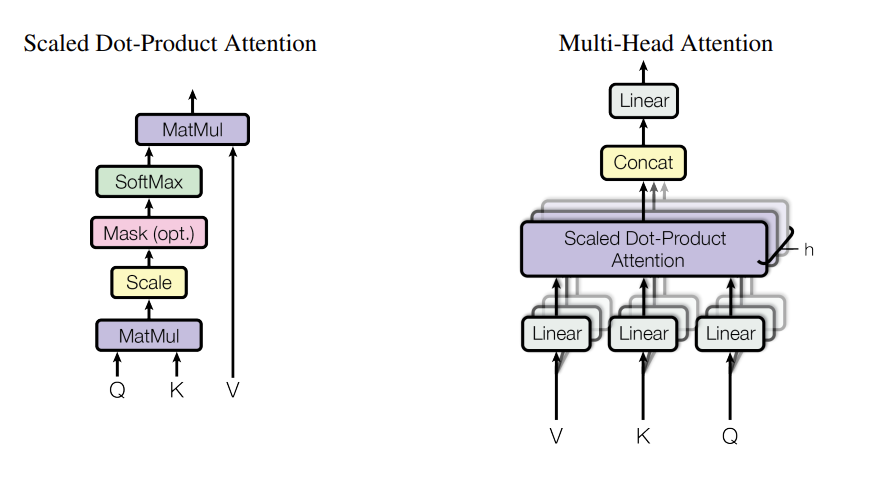

In [ ]:
# Multi-head attention simply applies multiple heads of attention, in parallel, and then
# concatenates their outputs.

class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention running in parallel. """
  def __init__(self, num_heads, n_embd, head_size, block_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(n_embd, head_size, block_size) for _ in range(num_heads)])

  def forward(self, x):
    return torch.cat([h(x) for h in self.heads], dim=-1)

In [ ]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, block_size, num_heads=4):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # The head size is automatically determined by having each attention head
        # computing n_embd/num_heads dimensional output, in parallel, so when we
        # concatenate, the total is equal to n_embd
        self.sa_heads = MultiHeadAttention(num_heads, n_embd, n_embd // num_heads, block_size)  # i.e., 4 heads of n_embd/num_heads dimensional self-attention

        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B,T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T,C)
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.sa_heads(x)  # apply one head of self-attention.  (B, T, C)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context.
        #
        # the job of this function is to take the (B, T) sequence, and extend
        # it to be (B, T+1), and then (B, T+2), and so on, until we have extended
        # it to `max_new_tokens` additional length.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens. we can never have more than
            # block_size tokens, or our position embedding table will over-run.
            idx_cond = idx[:, -block_size:]
            # get the predictions with current indices.  ignore the loss.
            logits, loss = self(idx_cond)
            # focus only on the last time step, so pluck out the last element in the time dimension
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution to get a single prediction for what comes next according to the given PDF
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
# Let's try again and see if the loss improves at all

model = BigramLanguageModel(vocab_size, n_embd, block_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
for steps in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if steps % eval_interval == 0 or steps == max_iters - 1:
        losses = estimate_loss()
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb.to(device), yb.to(device))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2227, val loss 4.2226
step 100: train loss 3.2269, val loss 3.2416
step 200: train loss 3.0102, val loss 3.0308
step 300: train loss 2.8442, val loss 2.8624
step 400: train loss 2.7256, val loss 2.7350
step 500: train loss 2.6608, val loss 2.6759
step 600: train loss 2.6175, val loss 2.6163
step 700: train loss 2.5739, val loss 2.5780
step 800: train loss 2.5319, val loss 2.5575
step 900: train loss 2.5186, val loss 2.5342
step 1000: train loss 2.4998, val loss 2.5084
step 1100: train loss 2.4796, val loss 2.4892
step 1200: train loss 2.4475, val loss 2.4635
step 1300: train loss 2.4472, val loss 2.4634
step 1400: train loss 2.4410, val loss 2.4372
step 1500: train loss 2.4375, val loss 2.4218
step 1600: train loss 2.4157, val loss 2.4175
step 1700: train loss 2.4074, val loss 2.4064
step 1800: train loss 2.4001, val loss 2.4104
step 1900: train loss 2.3910, val loss 2.3967
step 2000: train loss 2.3669, val loss 2.3975
step 2100: train loss 2.3653, val loss 2.3698


In [ ]:
# Let's see some output
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=2000)[0].tolist()))


And thik bridcowd,
This byer Kradiset bobe doe.
Sagr-d my dalleauss:
Want he us hathe.
War dilth anes wich my.

HDER:
Ay orou knowns, tof is he me mil;
I lincaes isee sen cin lat Helid ov the and Wing.

DWARYWIOROUCAING Fime litlis my de my sotur haiss hiwhy.

KEBEUSI VEfopetelave whom.

IET:
Whe akleoul---And do eviby, the my,
CHive winghired thoou gor-x's und kand thrupt for are;
De! mef thre maled, the af Pre?

WISo myay his bors,
Sheis:
Sadsal ther ghe thidin cour ay andy Iry thechan thove youn pand, bemary.

HIO:
Whastenm sorn an hing-w'n many weand mreand thot buld me thy wely or, wild.

My somy shintchs lom my iss dethapeings.

LAWIOPEARINY:
vet aredparst to os cok heit bose so ume his VO'g, hates:
Whit Clongscest?
Whoun iduche nee, oughe.

NENEHNIORIO gavelvince wal k she for mannd mand sofll bovelaivy, mors hons,
As demid hingt vingen,
Thie?
By
Ke thisto deiusorthe nof the sut nowip yourst what thavitt boust pe me welke, of sol O, theribed that do ive wout ighe an;
youke;
Go.

OK let's go back to the paper one more time.  Look at the following figure:
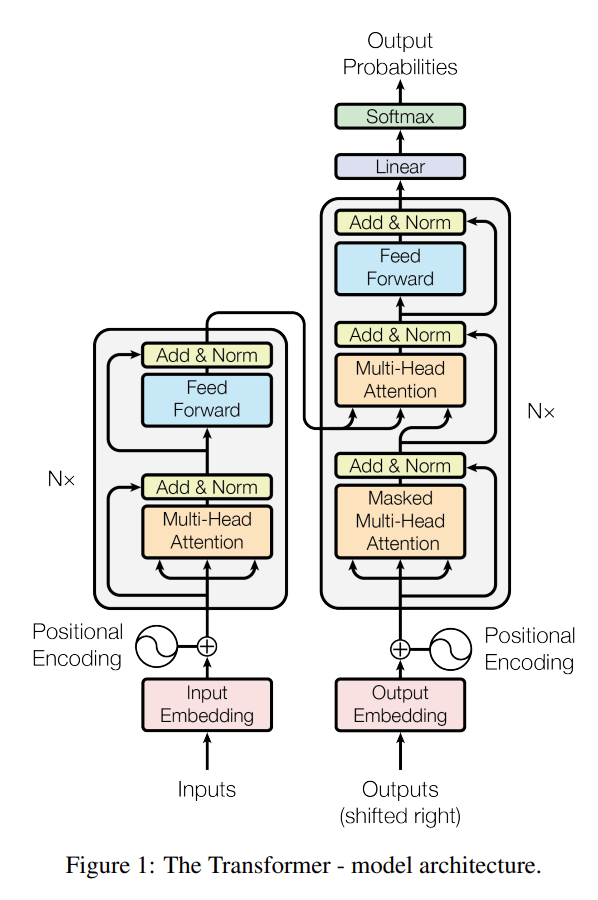

We are missing a few things here.  There's a feedforward part that is a simple MLP.  Let's add that.  This adds computation at a per-node level.

In [ ]:
class FeedForward(nn.Module):
  """ a simple linear  layer followed by a non-linearity. """
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, n_embd),
        nn.ReLU(),
    )

  def forward(self, x):
    # per-token level.  all tokens do this individually
    return self.net(x)

One way to think about what this is doing is that, before, the tokens had a chance to talk to each other, but they didn't have a chance to "think" about what they found.  This feedforward module is allowing the possibility to process the information more.  We also want to intersperse the communication with the computation.

In [ ]:
class Block(nn.Module):
  """ Transformer block: communication followed by computation. """

  def __init__(self, n_embd, n_head, block_size):
    super().__init__()

    # The head size is automatically determined by having each attention head
    # computing n_embd/n_head dimensional output, in parallel, so when we
    # concatenate, the total is equal to n_embd
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, n_embd, head_size, block_size)
    self.ffwd = FeedForward(n_embd)

  def forward(self, x):
    x = self.sa(x)
    x = self.ffwd(x)
    return x

In [ ]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, block_size, n_head=4):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head, block_size),
            Block(n_embd, n_head, block_size),
            Block(n_embd, n_head, block_size),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B,T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T,C)
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context.
        #
        # the job of this function is to take the (B, T) sequence, and extend
        # it to be (B, T+1), and then (B, T+2), and so on, until we have extended
        # it to `max_new_tokens` additional length.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens. we can never have more than
            # block_size tokens, or our position embedding table will over-run.
            idx_cond = idx[:, -block_size:]
            # get the predictions with current indices.  ignore the loss.
            logits, loss = self(idx_cond)
            # focus only on the last time step, so pluck out the last element in the time dimension
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution to get a single prediction for what comes next according to the given PDF
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
# Let's see how this helps out

model = BigramLanguageModel(vocab_size, n_embd, block_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
for steps in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if steps % eval_interval == 0 or steps == max_iters - 1:
        losses = estimate_loss()
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb.to(device), yb.to(device))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2116, val loss 4.2078
step 100: train loss 3.3035, val loss 3.3394
step 200: train loss 3.2819, val loss 3.3038
step 300: train loss 3.2432, val loss 3.2654
step 400: train loss 3.1726, val loss 3.1622
step 500: train loss 3.1058, val loss 3.0965
step 600: train loss 3.0373, val loss 3.0246
step 700: train loss 2.9329, val loss 2.9386
step 800: train loss 2.8700, val loss 2.8509
step 900: train loss 2.7632, val loss 2.7549
step 1000: train loss 2.6949, val loss 2.6965
step 1100: train loss 2.6570, val loss 2.6618
step 1200: train loss 2.6352, val loss 2.6317
step 1300: train loss 2.6153, val loss 2.6152
step 1400: train loss 2.5820, val loss 2.5836
step 1500: train loss 2.5826, val loss 2.5672
step 1600: train loss 2.5427, val loss 2.5529
step 1700: train loss 2.5206, val loss 2.5282
step 1800: train loss 2.5196, val loss 2.5218
step 1900: train loss 2.4968, val loss 2.5103
step 2000: train loss 2.4871, val loss 2.4779
step 2100: train loss 2.5000, val loss 2.4836


The model we created now is starting to suffer from optimization issues.  It is finally getting quite "deep".  There are a few things we can do about it.  If we go back to the figure in the paper, you notice this "arrow".  The arrow is a residual, which we first saw with ResNet.  

These are called skip connections, or residual connections.  The computation has a residual pathway, and we are free to fork off from the residual pathway, perform some computation, and project back to the pathway via addition.  

We go from the inputs to the targets via addition.  What this does, is addition distributes gradients equally to its two parts.  And so the loss back props across the computations all the way to the input, unimpeded.  This dramatically helps with the optimization.  Let's go back to the model code.

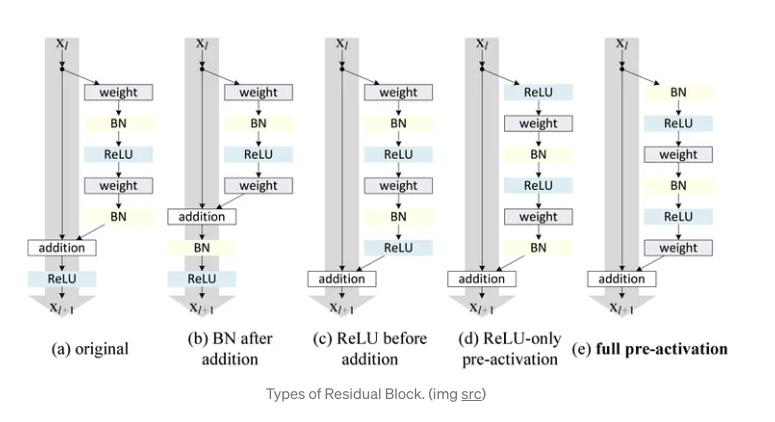

source: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

In [ ]:
class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention running in parallel. """
  def __init__(self, num_heads, n_embd, head_size, block_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(n_embd, head_size, block_size) for _ in range(num_heads)])

    # We also want to add this projection here.  This projects us back into
    # the residual pathway
    self.proj = nn.Linear(n_embd, n_embd)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out)
    return out

In [ ]:
class FeedForward(nn.Module):
  """ a simple linear  layer followed by a non-linearity. """
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),  # also, in the paper, the inner dimensionality is multiplied by 4, and then brought back down (happens on the side of the residual pathway)
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),  # <-- WE ADD THIS PROJECTION HERE TO GO BACK TO THE RESIDUAL PATHWAY
    )

  def forward(self, x):
    # per-token level.  all tokens do this individually
    return self.net(x)

In [ ]:
class Block(nn.Module):
  """ Transformer block: communication followed by computation. """

  def __init__(self, n_embd, n_head, block_size):
    super().__init__()

    # The head size is automatically determined by having each attention head
    # computing n_embd/n_head dimensional output, in parallel, so when we
    # concatenate, the total is equal to n_embd
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, n_embd, head_size, block_size)
    self.ffwd = FeedForward(n_embd)

  def forward(self, x):
    x = x + self.sa(x)  # <-- ADD SKIP CONNECTIONS HERE AND BELOW
    x = x + self.ffwd(x)
    return x

In [ ]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, block_size, n_head=4, n_layers=4):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size) for _ in range(n_layers)])
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B,T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T,C)
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context.
        #
        # the job of this function is to take the (B, T) sequence, and extend
        # it to be (B, T+1), and then (B, T+2), and so on, until we have extended
        # it to `max_new_tokens` additional length.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens. we can never have more than
            # block_size tokens, or our position embedding table will over-run.
            idx_cond = idx[:, -block_size:]
            # get the predictions with current indices.  ignore the loss.
            logits, loss = self(idx_cond)
            # focus only on the last time step, so pluck out the last element in the time dimension
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution to get a single prediction for what comes next according to the given PDF
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
# Ok let's see if any of this helps

model = BigramLanguageModel(vocab_size, n_embd, block_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
for steps in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if steps % eval_interval == 0 or steps == max_iters - 1:
        losses = estimate_loss()
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb.to(device), yb.to(device))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.5120, val loss 4.5043
step 100: train loss 2.7508, val loss 2.7572
step 200: train loss 2.5655, val loss 2.5627
step 300: train loss 2.4837, val loss 2.4871
step 400: train loss 2.4239, val loss 2.4256
step 500: train loss 2.3642, val loss 2.3938
step 600: train loss 2.3444, val loss 2.3472
step 700: train loss 2.3069, val loss 2.3200
step 800: train loss 2.2867, val loss 2.2959
step 900: train loss 2.2560, val loss 2.2797
step 1000: train loss 2.2347, val loss 2.2759
step 1100: train loss 2.2319, val loss 2.2435
step 1200: train loss 2.2255, val loss 2.2301
step 1300: train loss 2.1942, val loss 2.2211
step 1400: train loss 2.1910, val loss 2.2214
step 1500: train loss 2.1863, val loss 2.2152
step 1600: train loss 2.1683, val loss 2.2021
step 1700: train loss 2.1442, val loss 2.1934
step 1800: train loss 2.1411, val loss 2.1691
step 1900: train loss 2.1387, val loss 2.1678
step 2000: train loss 2.1055, val loss 2.1656
step 2100: train loss 2.0939, val loss 2.1484


In [ ]:
# Let's see some output
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=2000)[0].tolist()))



Clet if bridce.
Necking yet that sencurbeould andgrians me?
I'll suppaith fould word.
War dilaccaoes will my.

PDY OY my toughtountertof it here trithed;
Who eveirse:
Onot will is therevers, and Warpordion trabous lord dope litliser oncely spear; andsell, you lord's nor
To thind goodg
the them that
To What to draediby, with too rive wild in he poot of he trume known,
Tuppeakson; wors! my mongey.
Meporta,
Madere?

KIS:
Nor fropea!
Ardy, is:
Ardate these here hoin cour ace tey ire to chan you!
My timpand, bemary.
You contrame?
Is haven his me noble there threat swercaus in with lought.

DUComect frepey stiatces lord
Encastortly ivers.

LUCIO:
Abentily to-dedis?

Leccousir, iver bose so upon sire fe's tall:
Wh't Clorgs, sheirs,
And weat nees our mereanthbeak
these where
Awear soul. Dold lord's dous well not a veardossed
For hildeliderdips vone not with tyreet thee is ius done not the sut now prother is be than to brughter werell manoter her, where, death chotiur wort in forc;
your with 

OK!  This is the best loss we've seen so far.  However, there's still a chance of overfitting when we make this model really huge.  So let's add in a few regularization tricks.  First, we will put in some Dropout layers in a few places.  This randomly zeros some neurons during training to reduce the chances of memorization.

The other trick we will add is something called `LayerNorm`.  This is similar to `BatchNorm`, where we attempt to enforce a zero mean, unit variance on a mini-batch, however in `LayerNorm` it is row-wise instead of column-wise.  What this means is we do not need any running parameters and can do the normalization independently to each sample in a batch.

This is the final code for each of these modules.

In [ ]:
# Let's create a class to represent a single self-attention head
class Head(nn.Module):
  """ one head of self-attention """

  def __init__(self, n_embd, head_size, block_size, dropout):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)

    # this is not a parameter of the module.  and so we represent it as a "buffer"
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape

    k = self.key(x)    # (B, T, C)
    q = self.query(x)  # (B, T, C)

    # compute self attention scores ("affinities")
    wei = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, C) @ (B, C, T) --> (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    wei = F.softmax(wei, dim=-1)  # (B, T, T)
    wei = self.dropout(wei)

    # perform weighted aggregation of the values
    v = self.value(x)  # (B, T, C)
    out = wei @ v  # (B, T, T) @ (B, T, C) --> (B, T, C)
    return out


In [ ]:
class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention running in parallel. """
  def __init__(self, num_heads, n_embd, head_size, block_size, dropout):
    super().__init__()
    self.heads = nn.ModuleList([Head(n_embd, head_size, block_size, dropout) for _ in range(num_heads)])

    # We also want to add this projection here.  This projects us back into
    # the residual pathway
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

In [ ]:
class FeedForward(nn.Module):
  """ a simple linear  layer followed by a non-linearity. """
  def __init__(self, n_embd, dropout):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),  # also, in the paper, the inner dimensionality is multiplied by 4, and then brought back down (happens on the side of the residual pathway)
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),  # <-- WE ADD THIS PROJECTION HERE TO GO BACK TO THE RESIDUAL PATHWAY
        nn.Dropout(dropout),
    )

  def forward(self, x):
    # per-token level.  all tokens do this individually
    return self.net(x)

In [ ]:
class Block(nn.Module):
  """ Transformer block: communication followed by computation. """

  def __init__(self, n_embd, n_head, block_size, dropout):
    super().__init__()

    # The head size is automatically determined by having each attention head
    # computing n_embd/n_head dimensional output, in parallel, so when we
    # concatenate, the total is equal to n_embd
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, n_embd, head_size, block_size, dropout)
    self.ffwd = FeedForward(n_embd, dropout)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))  # <-- ADD SKIP CONNECTIONS HERE AND BELOW
    x = x + self.ffwd(self.ln2(x))
    return x

In [ ]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, block_size, n_head=4, n_layers=4, dropout=0.0):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B,T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T,C)
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context.
        #
        # the job of this function is to take the (B, T) sequence, and extend
        # it to be (B, T+1), and then (B, T+2), and so on, until we have extended
        # it to `max_new_tokens` additional length.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens. we can never have more than
            # block_size tokens, or our position embedding table will over-run.
            idx_cond = idx[:, -block_size:]
            # get the predictions with current indices.  ignore the loss.
            logits, loss = self(idx_cond)
            # focus only on the last time step, so pluck out the last element in the time dimension
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution to get a single prediction for what comes next according to the given PDF
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
# Alright!  Let's do this one more time:

model = BigramLanguageModel(vocab_size, n_embd, block_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
for steps in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if steps % eval_interval == 0 or steps == max_iters - 1:
        losses = estimate_loss()
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb.to(device), yb.to(device))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2318, val loss 4.2261
step 100: train loss 2.8911, val loss 2.9033
step 200: train loss 2.6206, val loss 2.6290
step 300: train loss 2.5244, val loss 2.5262
step 400: train loss 2.4405, val loss 2.4344
step 500: train loss 2.3812, val loss 2.4088
step 600: train loss 2.3615, val loss 2.3597
step 700: train loss 2.3186, val loss 2.3252
step 800: train loss 2.2907, val loss 2.2951
step 900: train loss 2.2487, val loss 2.2669
step 1000: train loss 2.2333, val loss 2.2627
step 1100: train loss 2.2265, val loss 2.2371
step 1200: train loss 2.2175, val loss 2.2180
step 1300: train loss 2.1893, val loss 2.2095
step 1400: train loss 2.1840, val loss 2.2131
step 1500: train loss 2.1726, val loss 2.1955
step 1600: train loss 2.1595, val loss 2.1859
step 1700: train loss 2.1376, val loss 2.1837
step 1800: train loss 2.1302, val loss 2.1529
step 1900: train loss 2.1277, val loss 2.1489
step 2000: train loss 2.0957, val loss 2.1504
step 2100: train loss 2.0908, val loss 2.1342


In [ ]:
# Let's see some output
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=2000)[0].tolist()))



CCOLADIR:
Nochwild, O love the dised bube to take O--
Sther, hands:
Whith foulquet toth cretlassay, away, my thans' prizerous
Yount
Murful I come millow!
Whoues is ententcintlaity therevets, and Will.

DUKENGE:
O, leling than.
His my deave speager is plaw you:
My, sweer
To this down my like thee killow in on have is all's thouNCHALET:
Go, me strow more-forgued known,
Turthe so;
Angred must wity allook, that Pried my ommer for be!
At you samards.
With Edwest hoing mustear tey Rrents I crown voulk nepter, bembry.
You conty me?
 so a cemysed-sencursetwerlentreand thouse, in with thesired, with couses:
It statchs lord
Is as we lopeises.

LALIOPEABRI:
To to-dedias!

KAMINGELY:
Sit Hese so umpeaser!
Fet hates:
Whith pongsuess?
Whown: duRTh nees our mer the beak-sir
werchince wall To with selp monderss well I man in wicks hows,
And I it himpe voniend.

CLWABERS:
But to meised the now the summen ip you ou what thought brust this belbam, on so hat there, drewat dotived:
The glear!;
To know ou

To create the final model, let's update some of the hyper-parameters to make the model a little larger, and the block size and embedding sizes a little more reasonable to learn the task for the final run.

In [ ]:
block_size = 256 # what is the maximum context length for predictions?
batch_size = 64 # how many independent sequences will we process in parallel?
n_embd = 384
max_iters = 5000
learning_rate = 3e-4
n_head = 6
n_layers = 6
eval_iters = 200
eval_interval = 100
dropout = 0.2

model = BigramLanguageModel(vocab_size, n_embd, block_size, n_head=n_head, n_layers=n_layers, dropout=dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

10.788929 M parameters


In [ ]:
for steps in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if steps % eval_interval == 0 or steps == max_iters - 1:
        losses = estimate_loss()
        print(f"step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb.to(device), yb.to(device))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

The loss is by far much better, but took much longer to train (> 60 mins).  This also requires a GPU.  I would not try to train this on a CPU.  That said, we finally showed some reasonable results.  Let's look at some example generation.

In [ ]:
# Let's see some output
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=5000)[0].tolist()))

This now looks much more like the Shakespeare text.  It is still nonsensical, but looks Shakespearean.  This is b/c it is just trained on the character level.  That said, it's pretty good!

To make this more sophisticated, we need:


*   A better tokenization strategy (e.g., sub-words)
*   A larger model (12 layers, 12 heads per layer, 768 embd dims)
*   A much larger dataset
*   That's it!

Content adapted from Andrej Karpathy's fantastic overview of GPTs and Transformers.  Here are some good links:

* https://karpathy.ai/zero-to-hero.html
* nanoGPT GitHub repo: https://github.com/karpathy/nanoGPT
* Attention Is All You Need Paper: https://arxiv.org/pdf/1706.03762.pdf
* GPT-3 Paper: https://arxiv.org/pdf/2005.14165.pdf



